# Imports

In [78]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns

In [79]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set()
sns.set_palette("bright")
color_bg_default = "#EAEAF2"
color_bg_inset = (245/256, 245/256, 250/256)
color_zoom_border = "#50668a"
colors = ["green", "red", sns.color_palette()[1], "blue", "orchid", sns.color_palette()[5], sns.color_palette()[8], sns.color_palette()[9], "black"]
markers = ["v", "o", "x", "^", "P", "s", "*"]
sns.set_palette("pastel")
colors_alt = [sns.color_palette()[2], sns.color_palette()[3], sns.color_palette()[1], sns.color_palette()[0]]
def initPlottingStuff(axlabelsize=20, ticklabelsize=18, legendfontsize=20):
    mpl.rcParams['axes.titlesize'] = axlabelsize
    mpl.rcParams['axes.labelsize'] = axlabelsize
    mpl.rcParams['ytick.labelsize'] = ticklabelsize
    mpl.rcParams['xtick.labelsize'] = ticklabelsize
    mpl.rcParams['legend.fontsize'] = legendfontsize
initPlottingStuff(20, 18, 20)
plt.ion()

# Set benchmark

In [378]:
cifar = 'C10'
ark = 'ark8' if cifar is 'C10' else 'ark7'
minimum = 21.31 if cifar is 'C10' else 21.54
maximum = 239.28 if cifar is 'C10' else 239.51

# Functions

In [310]:
def normalize(x, minimum, maximum):
    return ((x - minimum) / (maximum - minimum))
def countLayers(x):
    return len(x.replace('I', ''))

In [311]:
def plotTruePareto(ax, dataset, plot="validation"):
    suffix = "_testacc" if plot is "test" else ""
    fn = "../benchmarks/"+dataset+"/pareto"+suffix+".json"
    with open(fn) as json_file:
        data = json.load(json_file)
        trueFront = np.array(data['14']['fitness'])

        color="red"
        ax.scatter(trueFront[:,0], trueFront[:,1], s=2, color=color)
        
        blockyfront = generateBlockyFront(trueFront)
        ax.plot(blockyfront[:,0], blockyfront[:,1], lw=0.5, alpha=0.5, color=color, ls="dashed", label="Pareto front")
        ax.fill_between(np.append(blockyfront[:,0], 1), np.append(blockyfront[:,1],0), 2, alpha=0.2, color=color_zoom_border)

In [312]:
# Generates a np-array that contains the archive's values and their intersection points. This array can be used for plotting the line of the front.
def generateBlockyFront(np_archive):
    np_archive = np_archive[np.argsort(np_archive[:, 1])]
    np_archive = np_archive[np.argsort(np_archive[:, 1][::-1])]
    np_blocky_archive = np.zeros((len(np_archive[:,1]) * 2 + 1, 2))
    
    np_blocky_archive[0,1] = np_archive[0,1]
    i = 0
    for i in range(len(np_archive[:,0])):
        np_blocky_archive[i*2 + 1, :] = np_archive[i,:]
        np_blocky_archive[i*2 + 2, 0] = np_archive[i,0]
        if i != (len(np_archive[:,0]) - 1):
            np_blocky_archive[i*2 + 2, 1] = np_archive[i+1,1]
    
    return np_blocky_archive

# Load data

In [379]:
with open("../benchmarks/" + ark + "/" + ark + "_original.json") as f:
    dataset = json.load(f)

In [380]:
keys = []; values = []; test_acc = []; MMACs = []; val_acc = []; params = [];
for k, v in dataset.items():
    try:
        test_acc.append(v['test_acc'])
        val_acc.append(v['val_acc'])
        MMACs.append(v['MMACs'])
        params.append(v['Params'])
        keys.append(k)
        values.append(v)
    except:
        print("exception for key [", k, "]")

exception for key [ full ]


In [381]:
normalizedMMACs = list(map(lambda x: normalize(x, minimum, maximum), MMACs))

In [382]:
d = {'encoding': keys, 
     'val_acc': val_acc, 
     'test_acc': test_acc, 
     'MMACs': MMACs, 
     'normalizedMMACs': normalizedMMACs, 
     'params': params, 
     'numCells': list(map(lambda x: countLayers(x), keys)),
     'val_acc_dec': list(map(lambda x: x / 100, val_acc)),
     'test_acc_dec': list(map(lambda x: x / 100, test_acc)),
     '1 - normalizedMMACs': list(map(lambda x: 1 - x, normalizedMMACs))
    }
df = pd.DataFrame(d)

In [383]:
subdf = df.truncate(0, 1000)

# Check data

In [384]:
df.head()

,encoding,val_acc,test_acc,MMACs,normalizedMMACs,params,numCells,val_acc_dec,test_acc_dec,1 - normalizedMMACs
0,I1I1221I121121,91.65,91.29,128.15,0.490159,2475082,11,0.9165,0.9129,0.509841
1,12I22I1I22II22,91.52,91.06,142.73,0.557049,2779306,9,0.9152,0.9106,0.442951
2,12I22I1I22II21,91.41,90.25,135.89,0.525669,2351530,9,0.9141,0.9025,0.474331
3,I1I1221I121122,91.77,91.35,134.99,0.521540,2902858,11,0.9177,0.9135,0.478460
4,I1II1I1221III2,90.82,90.63,92.30,0.325687,1823594,7,0.9082,0.9063,0.674313


In [385]:
summary = df.describe()
print(summary)

            val_acc      test_acc         MMACs  normalizedMMACs  \
count  4.782969e+06  4.782969e+06  4.782969e+06     4.782969e+06   
mean   9.079623e+01  9.032578e+01  1.265762e+02     4.829390e-01   
std    1.037683e+00  1.043520e+00  2.401807e+01     1.101898e-01   
min    7.141000e+01  7.120000e+01  2.131000e+01     0.000000e+00   
25%    9.047000e+01  8.998000e+01  1.101400e+02     4.075331e-01   
50%    9.109000e+01  9.062000e+01  1.263700e+02     4.819929e-01   
75%    9.144000e+01  9.099000e+01  1.429000e+02     5.578291e-01   
max    9.249000e+01  9.190000e+01  2.392800e+02     1.000000e+00   

             params      numCells   val_acc_dec  test_acc_dec  \
count  4.782969e+06  4.782969e+06  4.782969e+06  4.782969e+06   
mean   1.951519e+06  9.333333e+00  9.079623e-01  9.032578e-01   
std    5.150002e+05  1.763834e+00  1.037683e-02  1.043520e-02   
min    5.471460e+05  0.000000e+00  7.141000e-01  7.120000e-01   
25%    1.578570e+06  8.000000e+00  9.047000e-01  8.998000e-01 

In [386]:
summary.drop(columns=['1 - normalizedMMACs', 'val_acc_dec', 'test_acc_dec']).to_latex()

'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &       val\\_acc &      test\\_acc &         MMACs &  normalizedMMACs &        params &      numCells \\\\\n\\midrule\ncount &  4.782969e+06 &  4.782969e+06 &  4.782969e+06 &     4.782969e+06 &  4.782969e+06 &  4.782969e+06 \\\\\nmean  &  9.079623e+01 &  9.032578e+01 &  1.265762e+02 &     4.829390e-01 &  1.951519e+06 &  9.333333e+00 \\\\\nstd   &  1.037683e+00 &  1.043520e+00 &  2.401807e+01 &     1.101898e-01 &  5.150002e+05 &  1.763834e+00 \\\\\nmin   &  7.141000e+01 &  7.120000e+01 &  2.131000e+01 &     0.000000e+00 &  5.471460e+05 &  0.000000e+00 \\\\\n25\\%   &  9.047000e+01 &  8.998000e+01 &  1.101400e+02 &     4.075331e-01 &  1.578570e+06 &  8.000000e+00 \\\\\n50\\%   &  9.109000e+01 &  9.062000e+01 &  1.263700e+02 &     4.819929e-01 &  1.951082e+06 &  9.000000e+00 \\\\\n75\\%   &  9.144000e+01 &  9.099000e+01 &  1.429000e+02 &     5.578291e-01 &  2.318570e+06 &  1.100000e+01 \\\\\nmax   &  9.249000e+01 &  9.190000e+01 &  2.392800e+02 &

In [387]:
def f1(x):
    return ('%2.4f' % x) + '%'
def f2(x):
    return ('%2.4f' % x)
summary.drop(columns=['1 - normalizedMMACs', 'val_acc_dec', 'test_acc_dec']).to_latex(formatters=[f1, f1, f2, f2, f2, f2, f2])

'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &       val\\_acc &      test\\_acc &        MMACs & normalizedMMACs &       params &     numCells \\\\\n\\midrule\ncount & 4782969.0000\\% & 4782969.0000\\% & 4782969.0000 &    4782969.0000 & 4782969.0000 & 4782969.0000 \\\\\nmean  &      90.7962\\% &      90.3258\\% &     126.5762 &          0.4829 & 1951519.3333 &       9.3333 \\\\\nstd   &       1.0377\\% &       1.0435\\% &      24.0181 &          0.1102 &  515000.2494 &       1.7638 \\\\\nmin   &      71.4100\\% &      71.2000\\% &      21.3100 &          0.0000 &  547146.0000 &       0.0000 \\\\\n25\\%   &      90.4700\\% &      89.9800\\% &     110.1400 &          0.4075 & 1578570.0000 &       8.0000 \\\\\n50\\%   &      91.0900\\% &      90.6200\\% &     126.3700 &          0.4820 & 1951082.0000 &       9.0000 \\\\\n75\\%   &      91.4400\\% &      90.9900\\% &     142.9000 &          0.5578 & 2318570.0000 &      11.0000 \\\\\nmax   &      92.4900\\% &      91.9000\\% &     239.2800 & 

# Statistics

## Correlation

In [322]:
correlation = df['val_acc'].corr(df['test_acc'])
print(correlation)

0.980669224432379


## Compress

In [323]:
encodings = df['encoding']
len(encodings)

4782969

In [325]:
def insert_reduction_layers (encoding):
    return (encoding[:4] + "." + encoding[4:8] + "." + encoding[8:12] + "." + encoding[12:])
encodings_with_reduction_layers = list(map(insert_reduction_layers, encodings))

In [326]:
def remove_identity_layers (encoding):
    return encoding.replace("I", '')

In [327]:
encodings_compressed = list(map(remove_identity_layers, encodings_with_reduction_layers))

In [328]:
print(len(encodings_compressed))
print(len(set(encodings_compressed)))

4782969
208537


In [329]:
print(encodings_compressed[5])

1.112.21.2


## Unique

In [330]:
def append_identity_until(encoding, until):
    toAdd = until - len(encoding)
    result = encoding
    for i in range(toAdd):
        result = result + "I"
    return result

def back_to_original_encoding(compressed_encoding):
    parts = compressed_encoding.split(".")
    return (append_identity_until(parts[0], 4) +
            append_identity_until(parts[1], 4) +
            append_identity_until(parts[2], 4) +
            append_identity_until(parts[3], 2))

In [331]:
unique_architectures = list(map(back_to_original_encoding, set(encodings_compressed)))

In [332]:
uniquedf = df[df['encoding'].isin(unique_architectures)]

In [333]:
uniquedf.describe()

,val_acc,test_acc,MMACs,normalizedMMACs,params,numCells,val_acc_dec,test_acc_dec,1 - normalizedMMACs
count,208537.000000,208537.000000,208537.000000,208537.000000,2.085370e+05,208537.000000,208537.000000,208537.000000,208537.000000
mean,68.633468,68.695506,144.828740,0.565623,2.233377e+06,10.912442,0.686335,0.686955,0.434377
std,1.775762,1.615155,26.983308,0.123794,5.586465e+05,2.008291,0.017758,0.016152,0.123794
min,45.180000,45.800000,21.540000,0.000000,6.624360e+05,0.000000,0.451800,0.458000,0.000000
25%,68.050000,68.320000,127.130000,0.484424,1.828708e+06,10.000000,0.680500,0.683200,0.346561
50%,69.310000,69.290000,146.180000,0.571822,2.274884e+06,11.000000,0.693100,0.692900,0.428178
75%,69.670000,69.600000,163.970000,0.653439,2.654980e+06,12.000000,0.696700,0.696000,0.515576
max,70.490000,70.510000,239.510000,1.000000,3.515300e+06,14.000000,0.704900,0.705100,1.000000


# Visualization

## Boxplots

In [334]:
def plot_boxplot(df, y, ylab):
    g = sns.boxplot(x="numCells", y=y,
                     data=df, color="b")
    g.set_xlabel("Number of cells in encoding")
    g.set_ylabel(ylab)
    
def plot_boxplot_valacc(df):
    plot_boxplot(df, 'val_acc', 'Validation accuracy')

def plot_boxplot_MMACs(df):
    plot_boxplot(df, 'MMACs', 'MMACs')

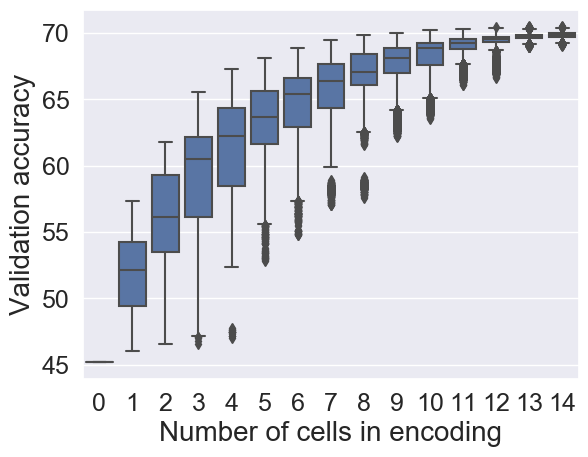

In [335]:
plot_boxplot_valacc(uniquedf)

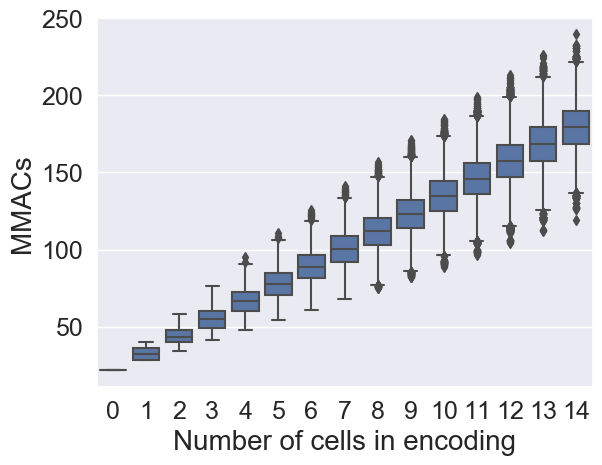

In [336]:
plot_boxplot_MMACs(uniquedf)

## Correlation val + test acc

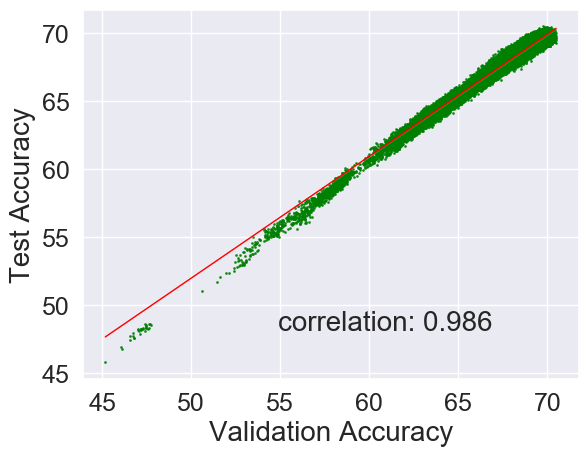

In [337]:
def plot_correlation(df):
    g = sns.regplot(df['val_acc'], df['test_acc'], color=colors[1], 
                    scatter_kws={'s': 1, 'color': colors[0]},
                    line_kws={'lineWidth': 1})
    g.set_xlabel("Validation Accuracy")
    g.set_ylabel("Test Accuracy")
    g.text(0.4, 0.2, 
           "correlation: {:1.3f}".format(df['val_acc'].corr(df['test_acc'])), 
           fontsize=20, transform=ax.transAxes)
    
plot_correlation(uniquedf)

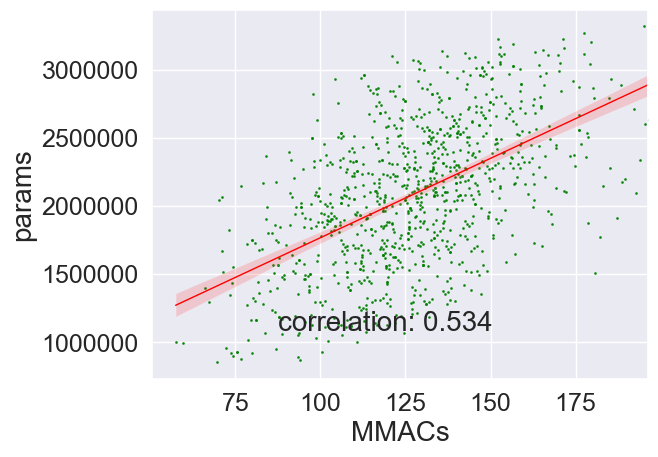

In [344]:
def plot_correlation_MMACs(df):
    g = sns.regplot(df['MMACs'], df['params'], color=colors[1], 
                    scatter_kws={'s': 1, 'color': colors[0]},
                    line_kws={'lineWidth': 1})
    g.set_xlabel("MMACs")
    g.set_ylabel("params")
    g.text(0.4, 0.2, 
           "correlation: {:1.3f}".format(df['MMACs'].corr(df['params'])), 
           fontsize=20, transform=ax.transAxes)
    
plot_correlation_MMACs(subdf)

## Scatter + Pareto Front

### Final

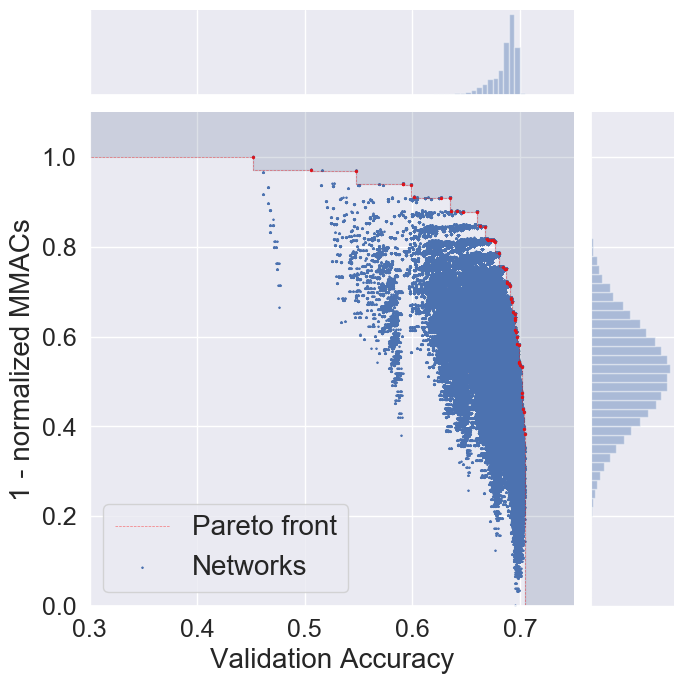

In [342]:
def scatter_and_pareto (df, ark):
    xlim = (0.6, 0.95) if ark is 'ark8' else (0.3, 0.75)
    g = sns.jointplot("val_acc_dec", "1 - normalizedMMACs", data=df,
                      kind="scatter",
                      xlim=xlim, ylim=(0, 1.1),
                      color="b", height=7, marker = 10, s =1, label="Networks")
    g.ax_joint.set_xlabel("Validation Accuracy")
    g.ax_joint.set_ylabel("1 - normalized MMACs")
    plotTruePareto(g.ax_joint, ark)
    g.ax_joint.legend(loc='lower left')

scatter_and_pareto(df, ark)

### Scratch

(0, 1.1)

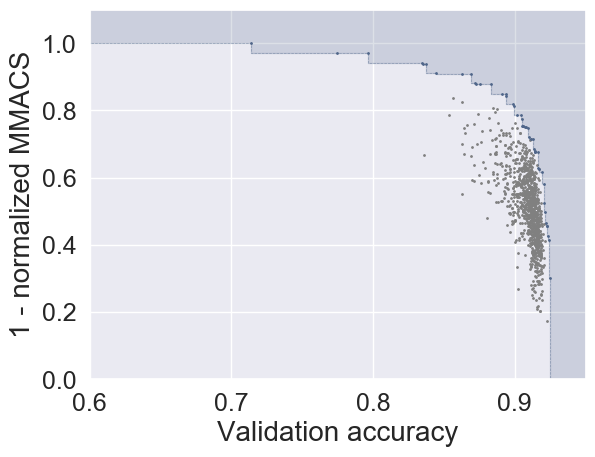

In [118]:
fig, ax = plt.subplots()
ax.scatter(subdf['val_acc_dec'], subdf['1 - normalizedMMACs'], s=1, c="grey")
plotTruePareto(ax, 'ark8')
ax.set_xlabel("Validation accuracy")
ax.set_ylabel("1 - normalized MMACS")
ax.set_xlim(0.6, 0.95)
ax.set_ylim(0, 1.1)

## Other

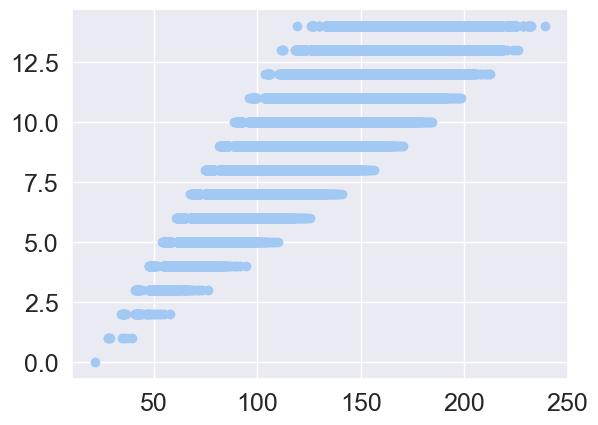

In [294]:
plt.scatter(uniquedf['MMACs'], uniquedf['numCells'])

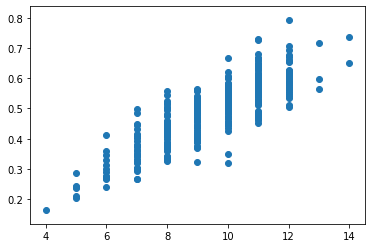

In [76]:
plt.scatter(subdf['numCells'], subdf['normalizedMMACs'])

,val_acc,test_acc,MMACs,normalizedMMACs,params,numCells
count,301.000000,301.000000,301.000000,301.000000,3.010000e+02,301.000000
mean,90.850399,90.366478,128.013821,0.489534,1.976590e+06,9.491694
std,0.951869,0.976286,24.209595,0.111068,5.272828e+05,1.855828
min,85.640000,85.000000,57.230000,0.164793,7.864420e+05,4.000000
25%,90.610000,90.000000,111.870000,0.415470,1.616138e+06,8.000000
50%,91.140000,90.660000,129.640000,0.496995,1.974250e+06,10.000000
75%,91.460000,91.030000,144.400000,0.564711,2.348778e+06,11.000000
max,92.070000,91.680000,193.840000,0.791531,3.048650e+06,14.000000


## Other

In [ ]:
sns.distplot(df['normalizedMMACs'], hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

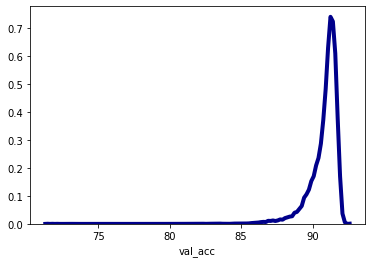

In [56]:
sns.distplot(df['val_acc'], hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})